# <b> Time Series Analysis for Climate Change in New Delhi </b>

## <b> Importing libraries </b>

In [150]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_predict, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

## <b> Loading datasets </b>

In [107]:
df = pd.read_csv('./assets//DailyDelhiClimate.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## <b> Exploratory analysis</b>

In [108]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [109]:
# Changing date column to datetime and adding new colummns

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

df["month"] = df.index.month
df["year"] = df.index.year

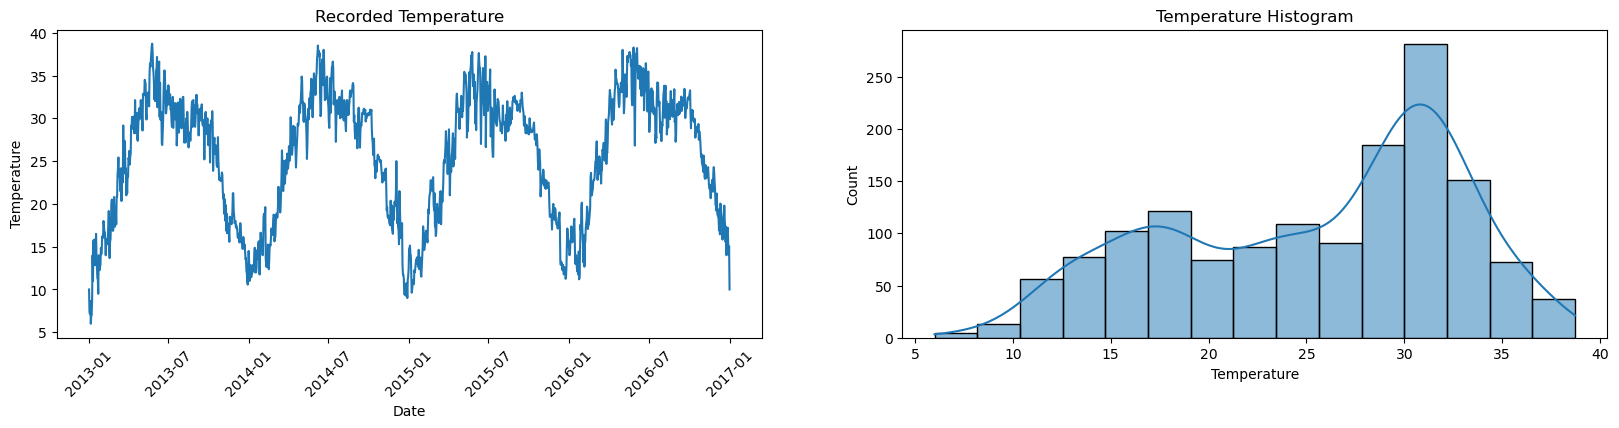

In [110]:
# Temperature per day

f = plt.figure(figsize=(20,4))

ax1 = f.add_subplot(121)
sns.lineplot(data=df, x="date", y="meantemp", ax=ax1)
plt.title("Recorded Temperature")
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.xticks(rotation=45)

ax2 = f.add_subplot(122)
sns.histplot(df["meantemp"], kde=True, ax=ax2)
plt.title("Temperature Histogram")
plt.ylabel("Count")
plt.xlabel("Temperature")

plt.show()

OBS: Lot of noise in the data. Clear seasonality per year.  
OBS: Left skewed data.

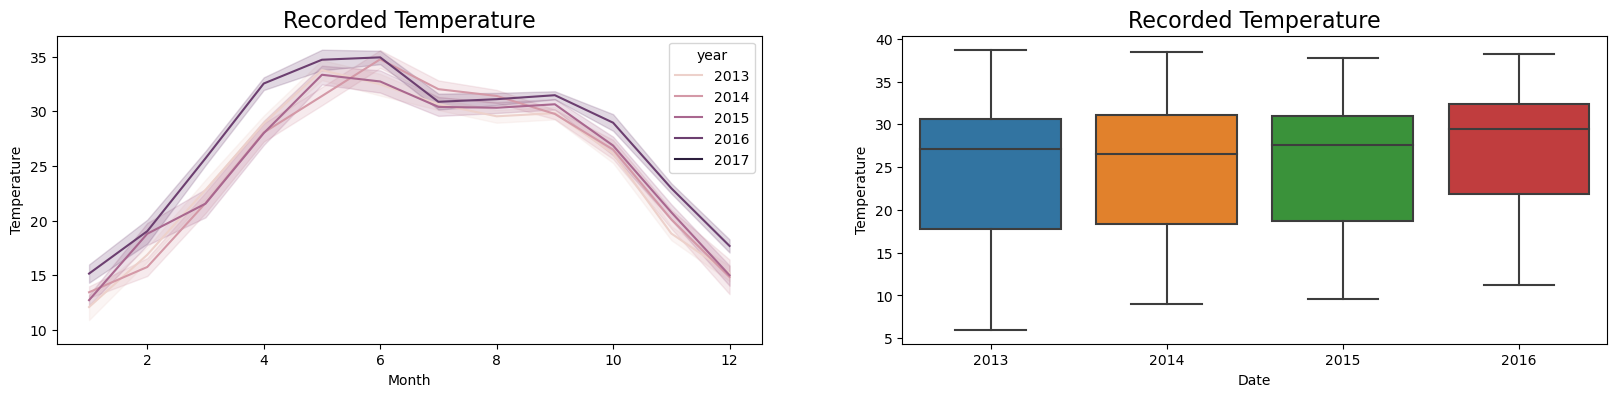

In [111]:
f = plt.figure(figsize=(20,4))

ax1 = f.add_subplot(121)
sns.lineplot(data=df, x="month", y="meantemp", hue="year", ax=ax1)
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Month")

ax2 = f.add_subplot(122)
sns.boxplot(data=df.iloc[:-1], x="year", y="meantemp", ax=ax2)
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")


plt.show()

OBS: Clear seasonality, all years follow the same trend.  
OBS: Highest mean temperature is in the last year. Similar averages for the first 3 years. 2016 temperatures are higher overall.

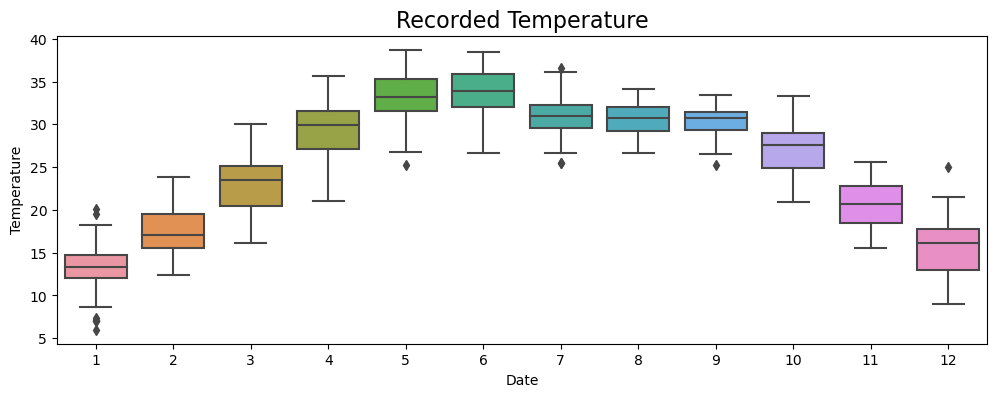

In [112]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.boxplot(data=df.iloc[:-1], x="month", y="meantemp")
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")

plt.show()

OBS: Higher temperatures in the middle of the year.

### <b> Seasonality of 365 days is too much. I will group calculate the average temperature of each month and the model will forecast the temperature of the next months </b>

In [122]:
month_year_df = df.groupby(df.index.to_period('M'))[["meantemp"]].mean()
month_year_df.index = month_year_df.index.astype('string')
month_year_df.head()

,meantemp
date,
2013-01,12.074770
2013-02,16.867560
2013-03,22.814209
2013-04,28.895119
2013-05,33.776767


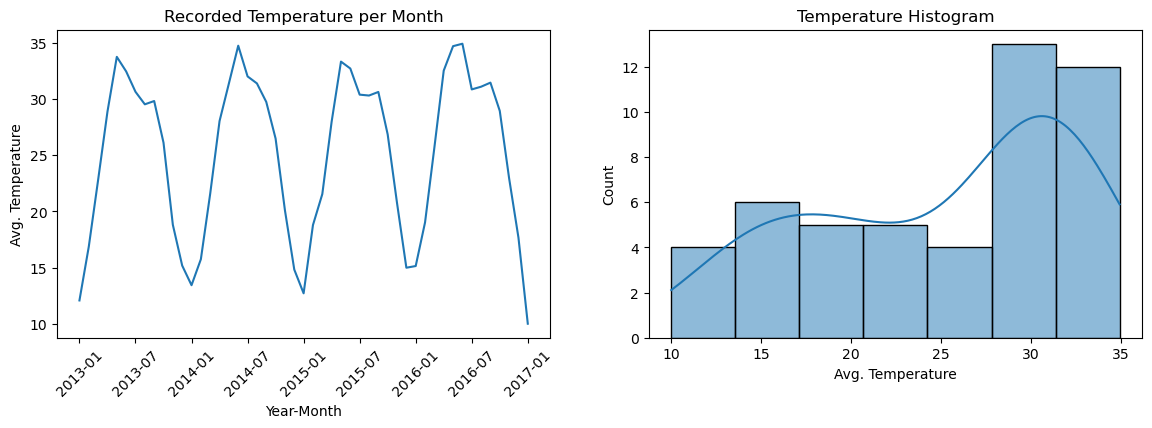

In [123]:
# Temperature per month-year

f = plt.figure(figsize=(14,4))

ax1 = f.add_subplot(121)
sns.lineplot(data=month_year_df, x="date", y="meantemp", ax=ax1)
plt.title("Recorded Temperature per Month")
plt.ylabel("Avg. Temperature")
plt.xlabel("Year-Month")
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

ax2 = f.add_subplot(122)
sns.histplot(month_year_df["meantemp"], kde=True, ax=ax2)
plt.title("Temperature Histogram")
plt.ylabel("Count")
plt.xlabel("Avg. Temperature")

plt.show()

OBS: Less noisy data.  
OBS: We have one day of 2017-01, it does not represent the average so I will drop that record.

In [ ]:
month_year_df = month_year_df.iloc[:-1]

In [137]:
# Tests for Stationarity - N0 KPSS: Data is stationary | N0 ADF: Data has a unit-root

warnings.filterwarnings('ignore')
kpss_test = kpss(month_year_df["meantemp"], 'ct')
adf_test = adfuller(month_year_df["meantemp"])

if kpss_test[1] > 0.05 and adf_test[1] > 0.05: print('Data do not give enough observations. Can not say it is stationary or not.')
elif kpss_test[1] <= 0.05 and adf_test[1] > 0.05: print('Data is not stationary')
elif kpss_test[1] > 0.05 and adf_test[1] <= 0.05: print('Data is stationary')
else: print('Data do not give enough observations.')

Data do not give enough observations. Can not say it is stationary or not.


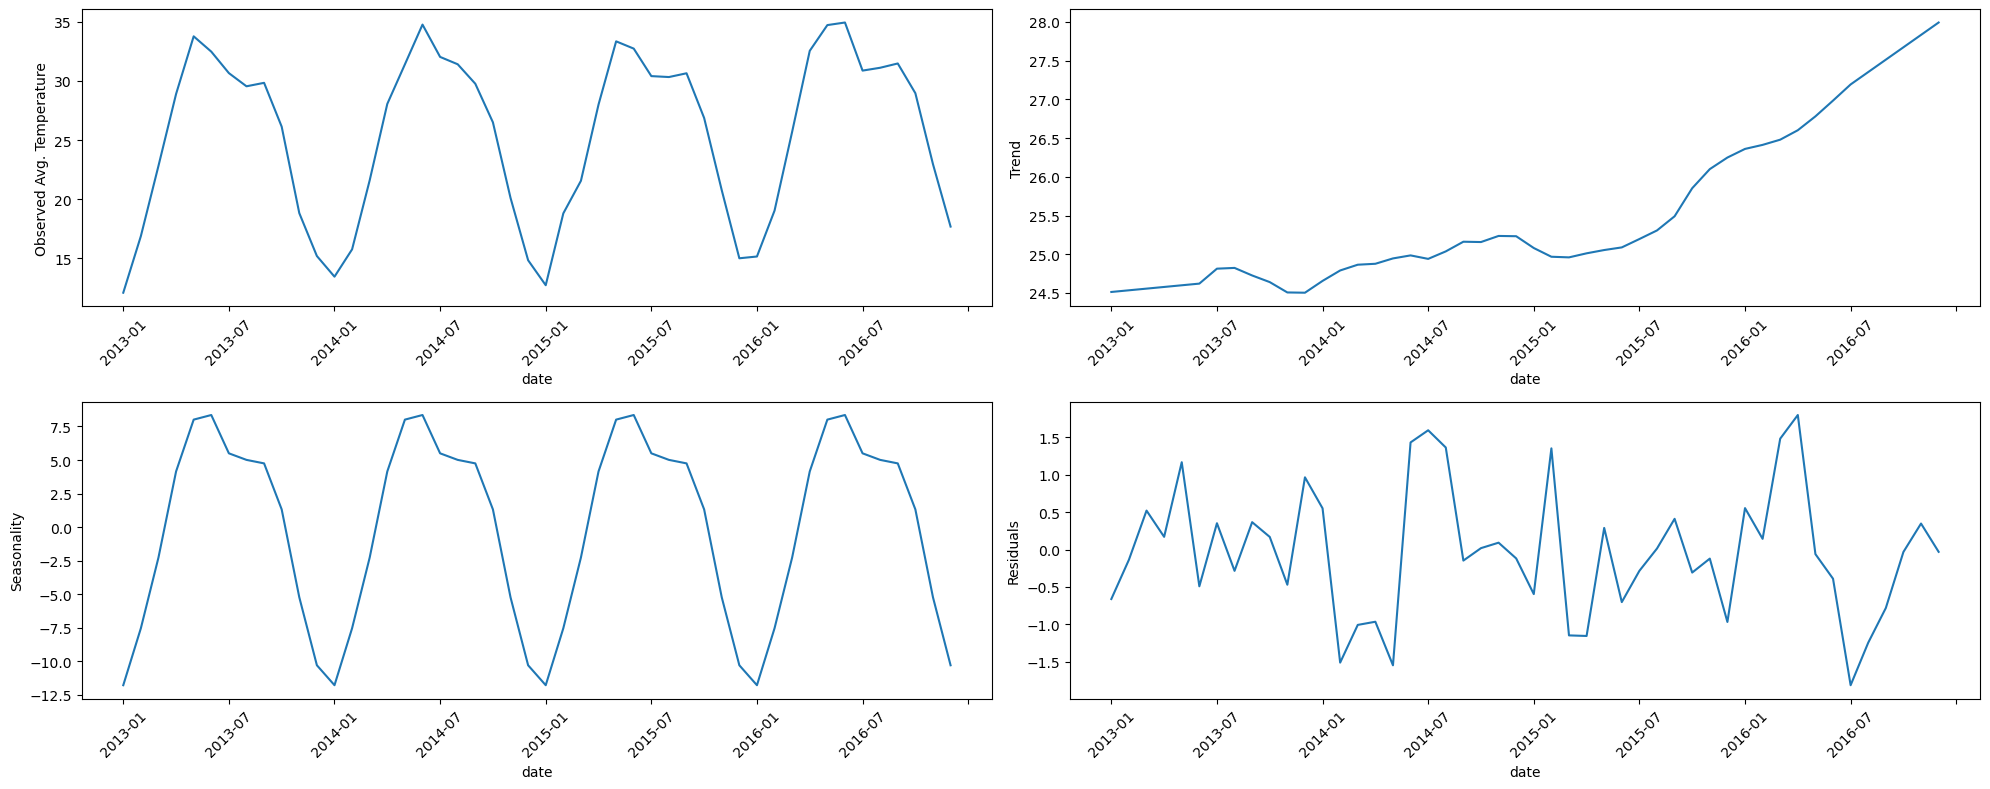

In [140]:
# Additive Decomposition - Because trend is not exponential

df_decomp = seasonal_decompose(month_year_df["meantemp"], model='additive', extrapolate_trend='freq', period=12)

f = plt.figure(figsize=(20, 8))

ax1 = f.add_subplot(221)
sns.lineplot(df_decomp.observed)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Observed Avg. Temperature')

ax2 = f.add_subplot(222)
sns.lineplot(df_decomp.trend)
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Trend')

ax3 = f.add_subplot(223)
sns.lineplot(df_decomp.seasonal)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Seasonality')

ax3 = f.add_subplot(224)
sns.lineplot(df_decomp.resid)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

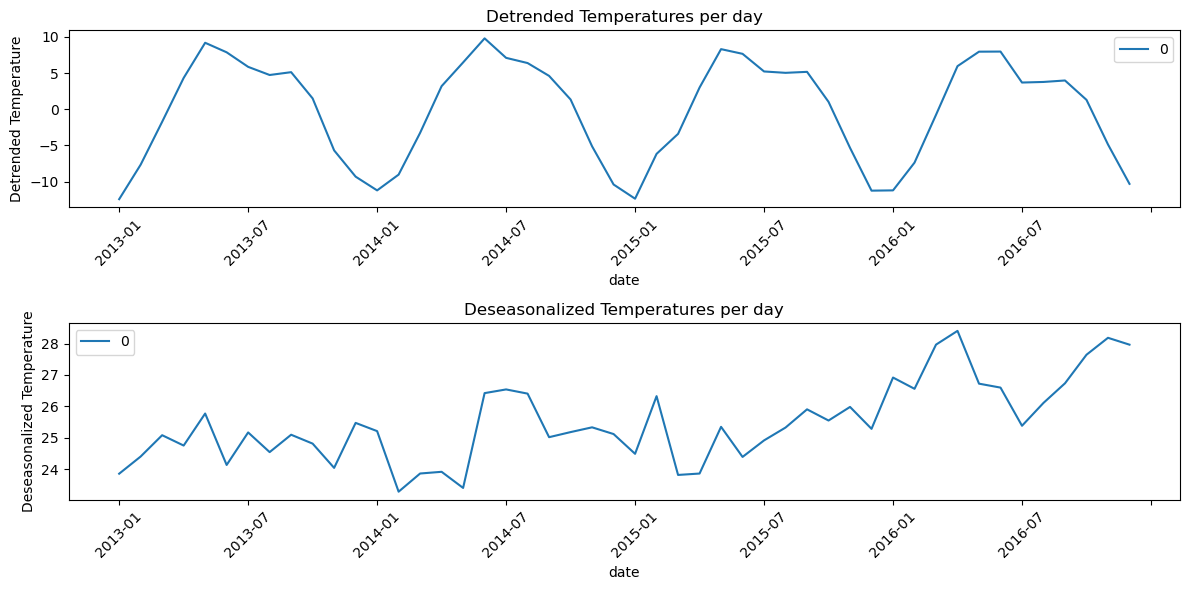

In [141]:
# Detrended temperature plot

f = plt.figure(figsize=(12, 6))

ax1 = f.add_subplot(211)
sns.lineplot(data=pd.DataFrame(df_decomp.observed - df_decomp.trend), ax=ax1)
ax1.set_ylabel('Detrended Temperature')
ax1.set_title('Detrended Temperatures per day')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

ax2 = f.add_subplot(212)
sns.lineplot(data=pd.DataFrame(df_decomp.observed - df_decomp.seasonal), ax=ax2)
ax2.set_ylabel('Deseasonalized Temperature')
ax2.set_title('Deseasonalized Temperatures per day')
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

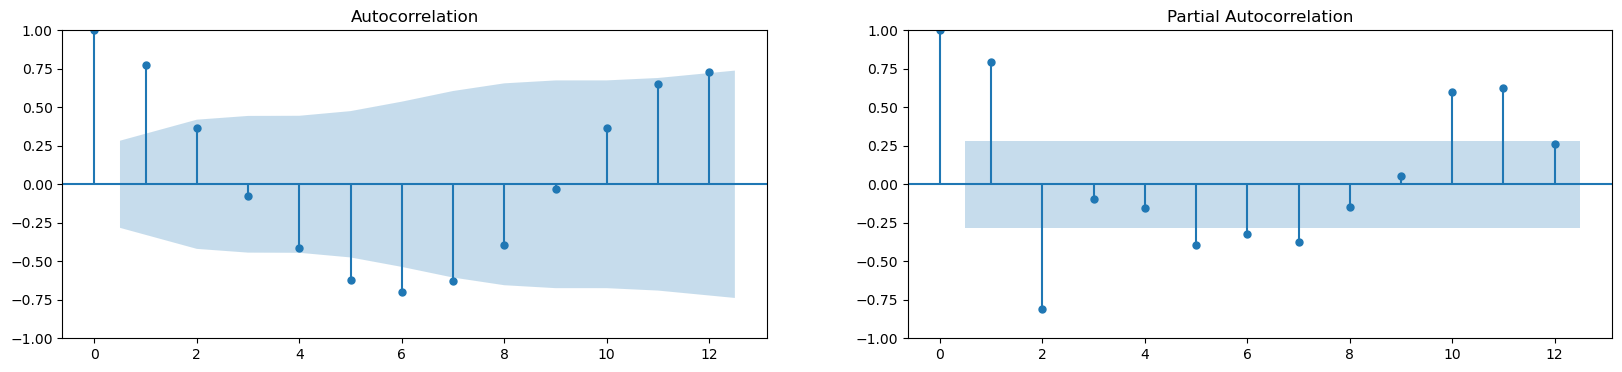

In [142]:
# Order of the AR and MA models

f = plt.figure(figsize=(20, 4))

ax1 = f.add_subplot(121)
plot_acf(month_year_df["meantemp"], lags=12, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(month_year_df["meantemp"], lags=12, method='ols', ax=ax2)

plt.show()

OBS: There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.  
OBS: For the SARIMA model: p=1, q=2

In [145]:
# Test for Stationarity for lags

seasonal_df = month_year_df["meantemp"].diff(12).dropna()

warnings.filterwarnings('ignore')
kpss_test = kpss(seasonal_df, 'ct')
adf_test = adfuller(seasonal_df)

if kpss_test[1] > 0.05 and adf_test[1] > 0.05: print('Data do not give enough observations. Can not say it is stationary or not.')
elif kpss_test[1] <= 0.05 and adf_test[1] > 0.05: print('Data is not stationary')
elif kpss_test[1] > 0.05 and adf_test[1] <= 0.05: print('Data is stationary')
else: print('Data do not give enough observations.')

Data is stationary


OBS: It was needed one difference to make the data stationary. d=1 in the SARIMA model.

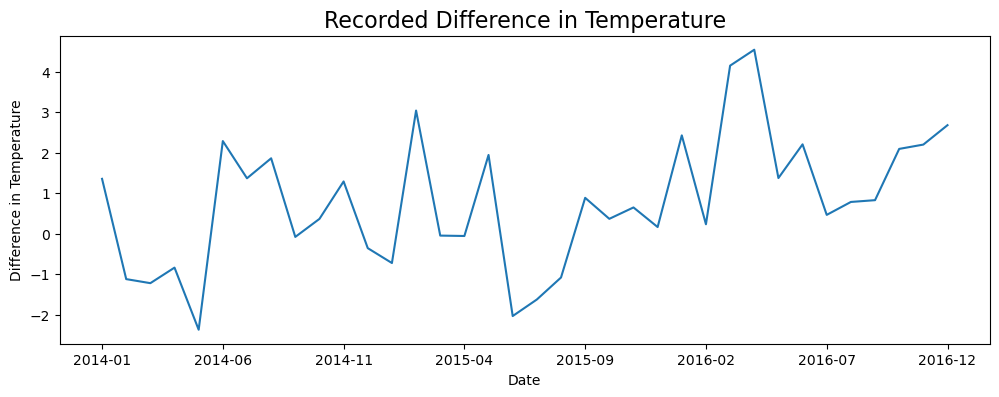

In [146]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
seasonal_df.plot()
plt.title("Recorded Difference in Temperature", fontsize=16)
plt.ylabel("Difference in Temperature")
plt.xlabel("Date")

plt.show()

In [147]:
seasonal_df.describe()

count    36.000000
mean      0.779833
std       1.630899
min      -2.371237
25%      -0.147473
50%       0.717894
75%       1.984372
max       4.547053
Name: meantemp, dtype: float64

OBS: Values oscilating close to 0.

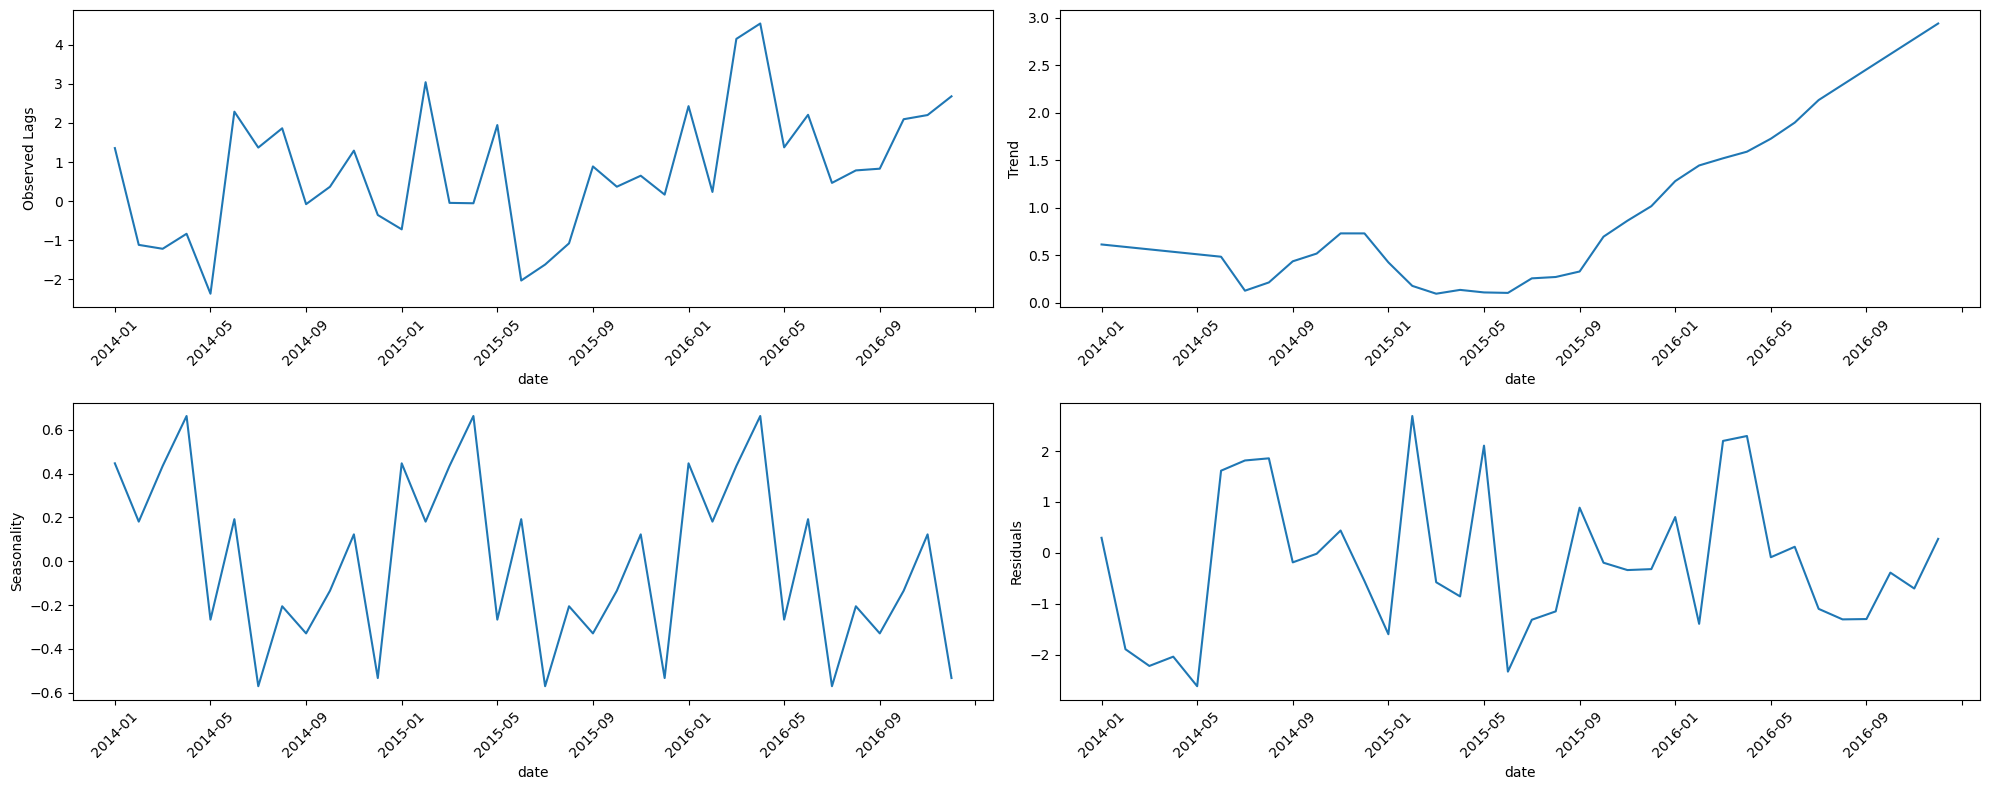

In [149]:
# Additive Decomposition

decomp_seasonal = seasonal_decompose(seasonal_df, model='additive', extrapolate_trend='freq', period=12)

f = plt.figure(figsize=(20, 8))

ax1 = f.add_subplot(221)
sns.lineplot(decomp_seasonal.observed)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Observed Lags')

ax2 = f.add_subplot(222)
sns.lineplot(decomp_seasonal.trend)
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Trend')

ax3 = f.add_subplot(223)
sns.lineplot(decomp_seasonal.seasonal)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Seasonality')

ax3 = f.add_subplot(224)
sns.lineplot(decomp_seasonal.resid)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

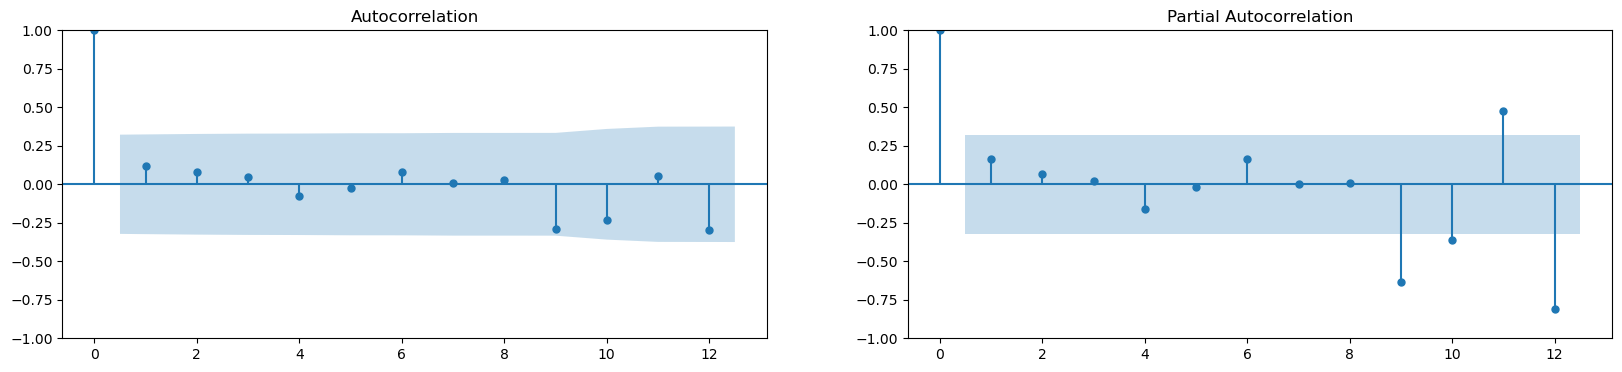

In [83]:
# Order of the AR and MA models for seasonal

f = plt.figure(figsize=(20, 4))

ax1 = f.add_subplot(121)
plot_acf(seasonal_df, lags=12, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(seasonal_df, lags=12, method='ols', ax=ax2)

plt.show()

OBS: p=0, q=0 for seasonal orders in the SARIMA model.

## <b> Model Selection </b>

In [160]:
results = pd.DataFrame(index=["ARIMA", "SARIMA"], columns=["AIC", "BIC"])

### <b> ARIMA </b>

In [161]:
arima_model = ARIMA(month_year_df["meantemp"], order=(1,1,2))
arima_fit = arima_model.fit()
results.loc["ARIMA", "AIC"] = arima_fit.aic
results.loc["ARIMA", "BIC"] = arima_fit.bic
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                   48
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -115.533
Date:                Tue, 04 Apr 2023   AIC                            239.067
Time:                        22:51:16   BIC                            246.467
Sample:                    01-01-2013   HQIC                           241.852
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2964      0.343      0.865      0.387      -0.375       0.968
ma.L1          0.5951      0.314      1.894      0.058      -0.021       1.211
ma.L2          0.3606      0.224      1.607      0.108      -0.079       0.800
sigma2         7.8302      2.178      3.595      0.000       3.561      12.099
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.89   Prob(JB):                         0.49
Heteroskedasticity (H):               1.04   Skew:                            -0.00
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <b> SARIMA </b>

In [164]:
sarima_model = SARIMAX(month_year_df["meantemp"], order=(1,1,2), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
results.loc["SARIMA", "AIC"] = sarima_fit.aic
results.loc["SARIMA", "BIC"] = sarima_fit.bic
sarima_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38845D+00    |proj g|=  6.75472D-02

At iterate    5    f=  1.37803D+00    |proj g|=  7.40691D-04

At iterate   10    f=  1.36632D+00    |proj g|=  1.31542D-02

At iterate   15    f=  1.36401D+00    |proj g|=  6.49729D-03

At iterate   20    f=  1.36214D+00    |proj g|=  1.11671D-03

At iterate   25    f=  1.36203D+00    |proj g|=  2.29117D-04

At iterate   30    f=  1.36201D+00    |proj g|=  3.98455D-05

At iterate   35    f=  1.36201D+00    |proj g|=  1.12646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            meantemp   No. Observations:                   48
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 12)   Log Likelihood                 -65.376
Date:                             Tue, 04 Apr 2023   AIC                            138.752
Time:                                     22:53:13   BIC                            144.974
Sample:                                 01-01-2013   HQIC                           140.900
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8340      0.280     -2.978      0.003      -1.383      -0.285
ma.L1          0.1983     21.148      0.009      0.993     -41.250      41.647
ma.L2         -0.8007     16.861     -0.047      0.962     -33.848      32.246
sigma2         2.2982     48.202      0.048      0.962     -92.176      96.773
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.84   Prob(JB):                         0.31
Heteroskedasticity (H):               1.25   Skew:                             0.63
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
display(results)

,AIC,BIC
ARIMA,239.066771,246.467362
SARIMA,138.752495,144.973887


OBS: Much better performance for SARIMA model as expected.

### <b> SARIMA Analysis </b>

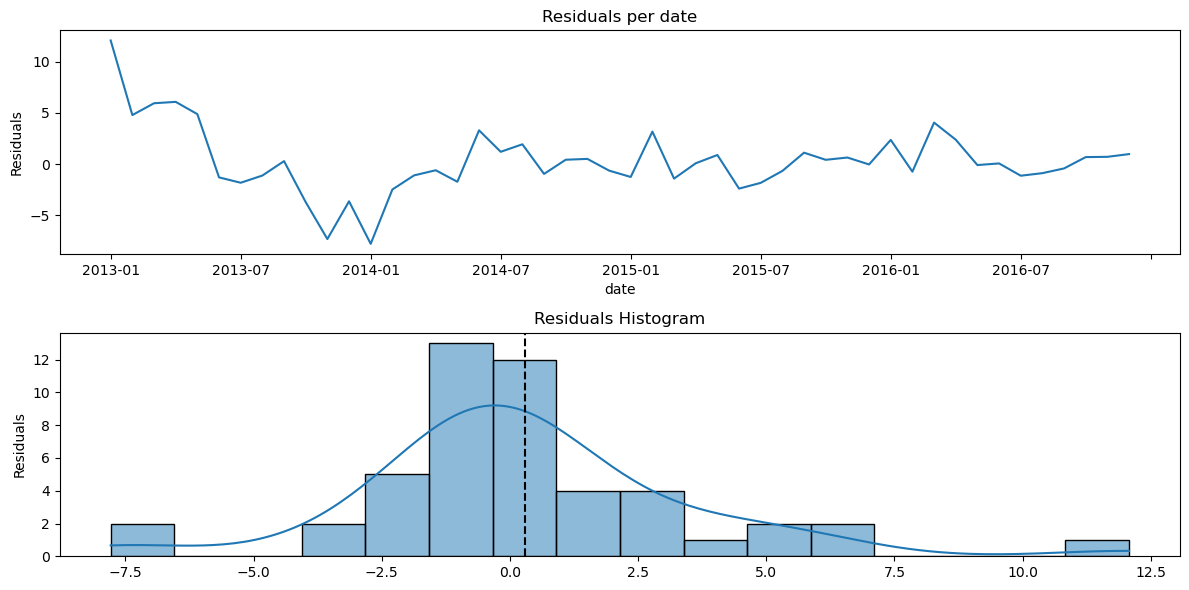

In [167]:
# Plotting the residuals

f = plt.figure(figsize=(12, 6))

ax1 = f.add_subplot(211)
sns.lineplot(sarima_fit.resid, ax=ax1)
plt.ylabel('Residuals')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.set_title('Residuals per date')

ax2 = f.add_subplot(212)
sns.histplot(sarima_fit.resid, kde=True, ax=ax2)
ax2.axvline(sarima_fit.resid.mean(), color='k',linestyle='--')
plt.ylabel('Residuals')
ax2.set_title('Residuals Histogram')

plt.tight_layout()
plt.show()

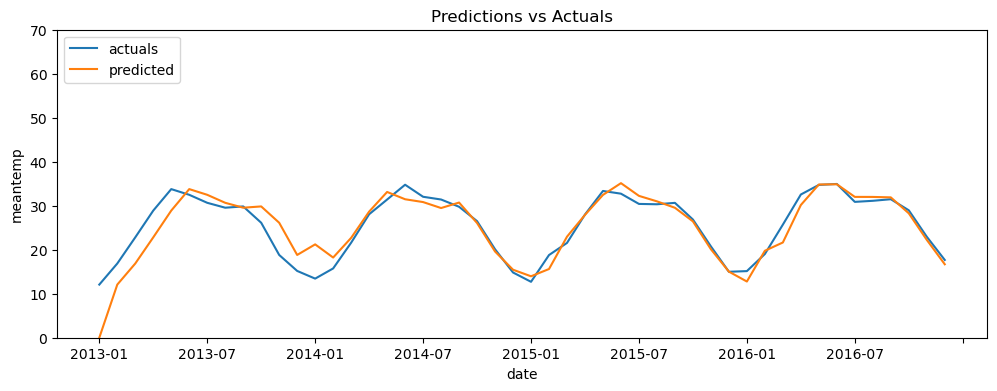

In [187]:
# Compare predictions vs Actuals adding Anomalies

predictions = sarima_fit.get_prediction().predicted_mean
predictions.index = predictions.index.to_period('M').astype('string')

f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
ax.set_ylim([0, 70])
sns.lineplot(data=month_year_df, x="date", y="meantemp", label='actuals', ax=ax)
sns.lineplot(predictions, label='predicted', ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend(loc='upper left')
plt.title('Predictions vs Actuals')

plt.show()

### <b> Anomaly Detection in the predictions </b>

In [190]:

predictions_ci = sarima_fit.get_prediction().conf_int(alpha=0.05)
predictions_ci["actual_temp"] = month_year_df["meantemp"]
predictions_ci["anomaly"] = np.where((predictions_ci["actual_temp"] > predictions_ci["upper meantemp"]) | (predictions_ci["actual_temp"] < predictions_ci["lower meantemp"]), 1, 0)
print('{}% of anomalies detected.'.format(round(predictions_ci["anomaly"].sum()/predictions_ci["anomaly"].count()),2))

0% of anomalies detected.


## <b> Forecasting View </b>

In [193]:
forecast.predicted_mean

2017-01-01    17.037305
2017-02-01    20.809540
2017-03-01    27.580076
2017-04-01    34.349690
2017-05-01    36.594553
2017-06-01    36.757483
2017-07-01    32.732471
2017-08-01    32.934865
2017-09-01    33.330061
2017-10-01    30.785282
2017-11-01    24.803239
2017-12-01    19.499862
Freq: MS, Name: predicted_mean, dtype: float64

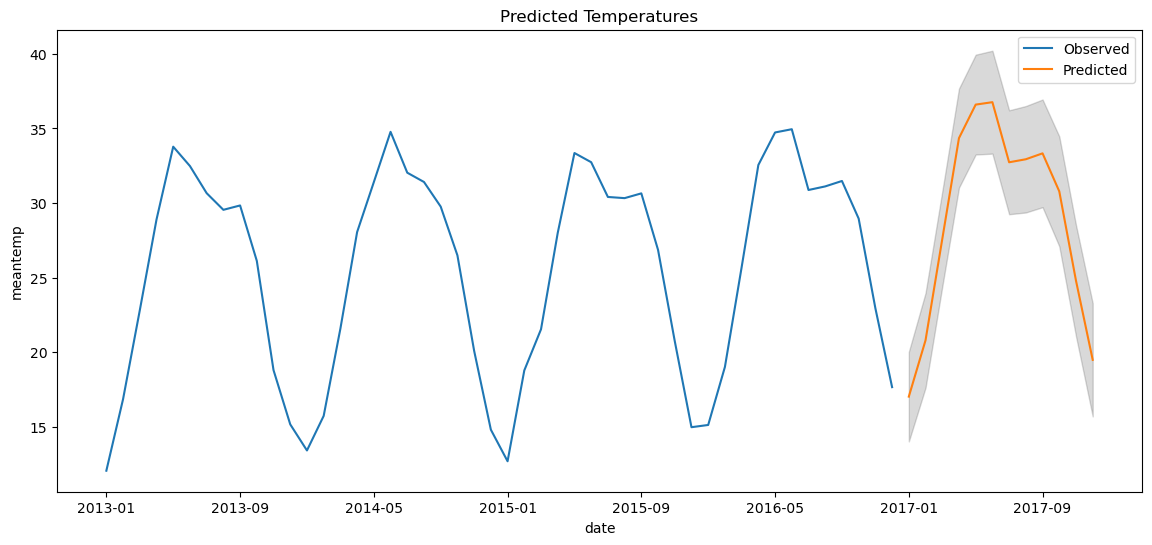

In [220]:
forecast = sarima_fit.get_forecast(12)
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_mean.index.to_period('M').astype('string')

confidence_interval = forecast.conf_int(alpha=0.05) # 95% confidence

lower_series = pd.Series(confidence_interval.iloc[:, 0])
lower_series.index = lower_series.index.to_period('M').astype('string')
upper_series = pd.Series(confidence_interval.iloc[:, 1])
upper_series.index = upper_series.index.to_period('M').astype('string')


f = plt.figure(figsize=(14,6))

ax = f.add_subplot(111)
sns.lineplot(month_year_df["meantemp"], label='Observed')
sns.lineplot(forecast_mean, label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                color='k', alpha=.15)
plt.title('Predicted Temperatures')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend()
plt.show()

TO DO: Compare forecast with actual values. Dataset available in Kaggle.  
TO DO: Try Prophet and other models.